In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.interpolate import CubicSpline
from matplotlib.font_manager import FontProperties
from itertools import product
from sklearn.metrics import r2_score
import csv
from vme import VME
from envelope import spline_envelope
import itertools

In [11]:
# adjusted R-squared
def r2_score_adjusted(y, y_pred, featurecount):
    n = len(y)
    return 1 - (1-r2_score(y, y_pred)) * (n-1)/(n-featurecount-1)

# AIC
def calculate_aic(y, y_pred, k):
    sse = np.sum((y - y_pred) ** 2)
    n = len(y)
    aic = n * np.log(sse / n) + 2 * k
    return aic

# BIC
def calculate_bic(y, y_pred, k):
    sse = np.sum((y - y_pred) ** 2)
    n = len(y)
    bic = n * np.log(sse / n) + k * np.log(n)
    return bic

# импорт временного ряда

In [12]:
# linux path
# path1 = './'
# path2 = '/'

# windows path
path1 = '.\\'
path2 = '\\'

In [34]:
DS = pd.read_csv("KwhConsumptionBlower78_1.csv", decimal=',')
DS['datetime'] = pd.to_datetime(DS['TxnDate'].astype(str) + ' ' + DS['TxnTime'].astype(str))
DS['Consumption'] = pd.to_numeric(DS['Consumption'])
DS.set_index("datetime", inplace=True)
DS.dropna(inplace=True)
TS = DS['Consumption']
TS = TS.sort_index()
TS

datetime
2022-01-01 00:22:28     1.030
2022-01-01 00:42:33     0.904
2022-01-01 01:01:51     0.904
2022-01-01 01:41:48     1.850
2022-01-01 02:22:52     1.878
                        ...  
2022-01-20 22:04:41     5.732
2022-01-20 22:26:36     5.928
2022-01-20 22:47:26     6.432
2022-01-20 23:27:57    13.092
2022-01-20 23:47:55     6.788
Name: Consumption, Length: 1228, dtype: float64

In [35]:
index = TS.index
index

DatetimeIndex(['2022-01-01 00:22:28', '2022-01-01 00:42:33',
               '2022-01-01 01:01:51', '2022-01-01 01:41:48',
               '2022-01-01 02:22:52', '2022-01-01 02:47:00',
               '2022-01-01 03:06:30', '2022-01-01 03:27:40',
               '2022-01-01 03:47:47', '2022-01-01 04:07:36',
               ...
               '2022-01-20 20:21:01', '2022-01-20 20:44:24',
               '2022-01-20 21:03:39', '2022-01-20 21:24:09',
               '2022-01-20 21:43:55', '2022-01-20 22:04:41',
               '2022-01-20 22:26:36', '2022-01-20 22:47:26',
               '2022-01-20 23:27:57', '2022-01-20 23:47:55'],
              dtype='datetime64[ns]', name='datetime', length=1228, freq=None)

In [36]:
k = 4 # количество декомпозиций
f = TS[::].values # значения временного ряда, в дальнейшем - вычеты
u = np.zeros(k, dtype=list) # декомпозиции
low = np.zeros(k, dtype=list) # верхние огибающие
high = np.zeros(k, dtype=list) # нижние огибающие


for i in range(0,k):
    low_envelope, high_envelope = spline_envelope(f,dmin=1,dmax=1)
    low[i] = low_envelope
    high[i] = high_envelope
    # u[i] = (high_envelope + low_envelope)/2
    u[i] = f - (high_envelope + low_envelope)/2
    f = f - u[i]


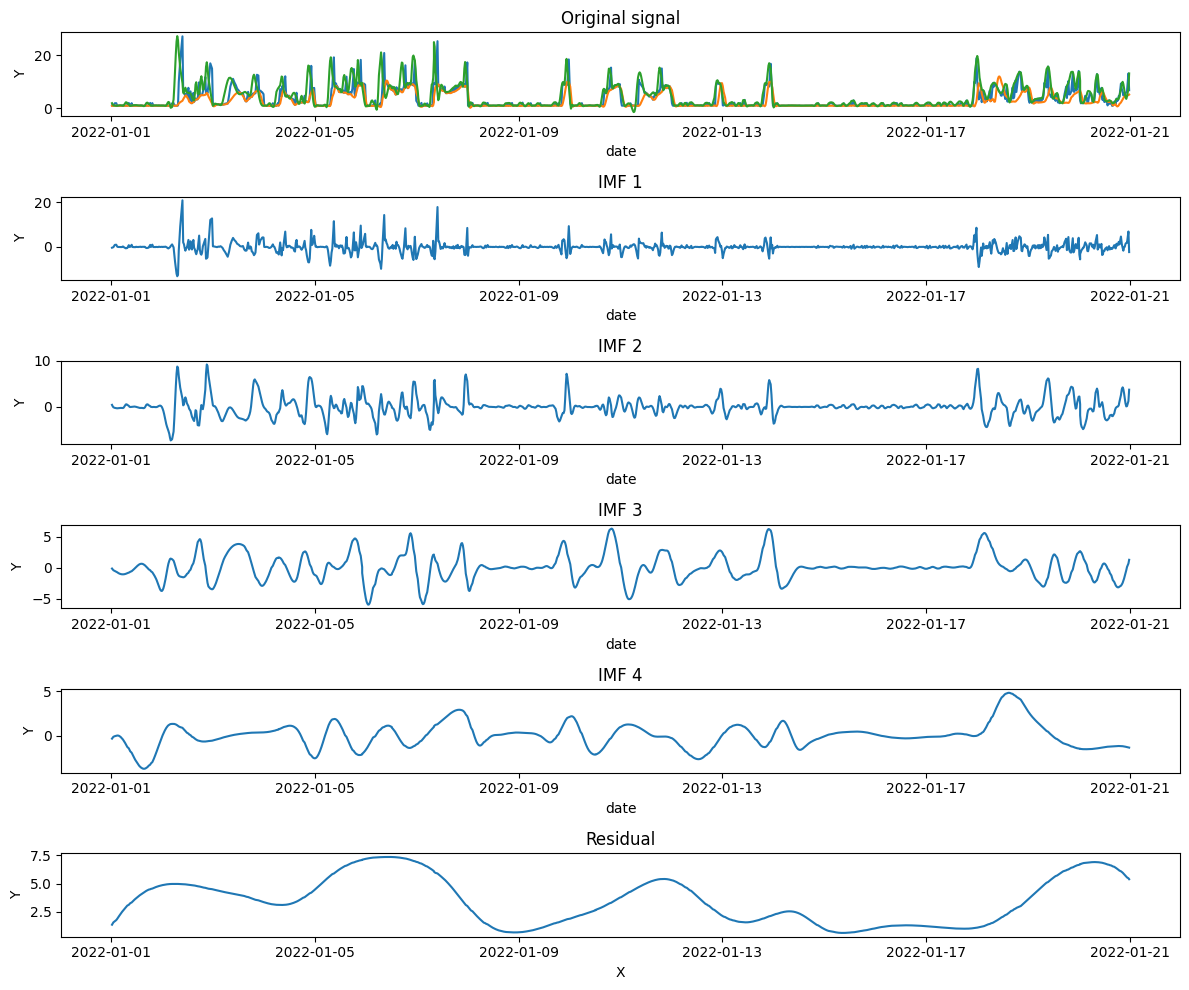

In [37]:
fig, axs = plt.subplots(figsize=(12,10), nrows=k+2)

# plt.subplot(2,1,1)
axs[0].set(xlabel = 'date', ylabel='Y')
axs[0].plot(index, TS[::].values)
axs[0].plot(index, low[0])
axs[0].plot(index, high[0])
axs[0].set_title('Original signal')

# plt.subplot(2,1,2)
for i in range(k):
    axs[i+1].plot(index, u[i])
    axs[i+1].set_title(f'IMF {i+1}')
    axs[i+1].set(xlabel = 'date', ylabel='Y')

# plt.subplot(2,2,2)
axs[k+1].plot(index, f)
plt.title('Residual')
plt.xlabel('X')
plt.ylabel('Y')
# plt.legend(['Оригинальный сигнал', 'Нижняя огибающая', 'Верхняя огибающая', 'Средняя огибающих'])

plt.tight_layout()

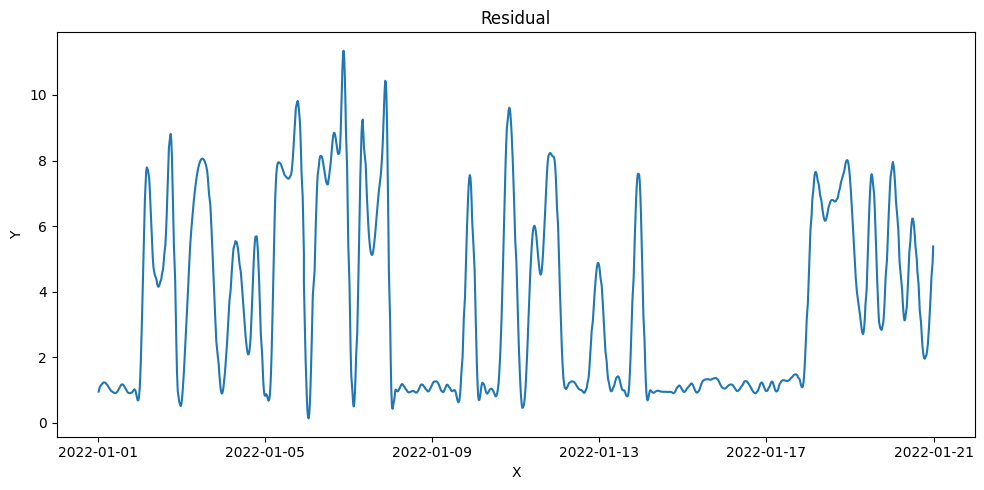

In [38]:
fig, axs = plt.subplots(figsize=(10,5), nrows=1)


sum_imfs = 0
for i in range(2,k):
    sum_imfs += u[i]

sum_imfs += f
# axs.plot(index, TS[::].values)
axs.plot(index, sum_imfs)
plt.title('Residual')
plt.xlabel('X')
plt.ylabel('Y')
# plt.legend(['Оригинальный сигнал', 'Нижняя огибающая', 'Верхняя огибающая', 'Средняя огибающих'])

plt.tight_layout()

In [18]:
# Trend = f + u[3]
# Component_of_TS = Trend[::]
# Component_name = "Trend"
# range_of_imfs = range(8)

# Season = u[2]+u[1]
# Component_of_TS = Season[::]
# Component_name = "Season"
# range_of_imfs = range(1,8)

# Noise = u[0]
# Component_name = "Noise"
# range_of_imfs = range(9, 1, -1)
# Component_of_TS = Noise[::]

# тестовый анализ

In [11]:
len(TS)

1228

In [12]:
TS

datetime
2022-01-01 00:22:28     1.030
2022-01-01 00:42:33     0.904
2022-01-01 01:01:51     0.904
2022-01-01 01:41:48     1.850
2022-01-01 02:22:52     1.878
                        ...  
2022-01-20 22:04:41     5.732
2022-01-20 22:26:36     5.928
2022-01-20 22:47:26     6.432
2022-01-20 23:27:57    13.092
2022-01-20 23:47:55     6.788
Name: Consumption, Length: 1228, dtype: float64

In [39]:
alpha = 500
omega_init = 1
tau = 1
fs = 20000
tol = 1e-6

In [40]:
imf, _, _ = VME(TS, Alpha=alpha, omega_int=omega_init, fs=fs, tau=tau, tol=tol)

C:\Users\George\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\George\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


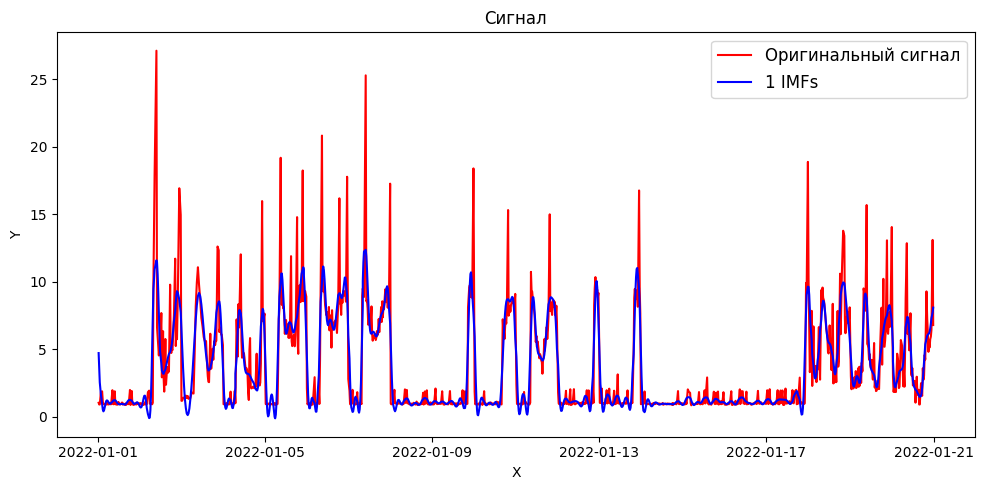

In [41]:
fig, axs = plt.subplots(figsize=(10,5), nrows=1)


axs.plot(index, TS, color="#ff0000")
axs.plot(index, imf, color="#0000ff")
plt.title('Сигнал', fontsize=12)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(['Оригинальный сигнал', '1 IMFs'], prop=FontProperties(size=12))

plt.tight_layout()

In [43]:
Trend = f + u[3]
Component_of_TS = Trend[::]

In [46]:
alpha = 5000
omega_init = 1
tau = 0

fs = 20000
tol = 1e-6

In [47]:
imf, _, _ = VME(TS, Alpha=alpha, omega_int=omega_init, fs=fs, tau=tau, tol=tol)

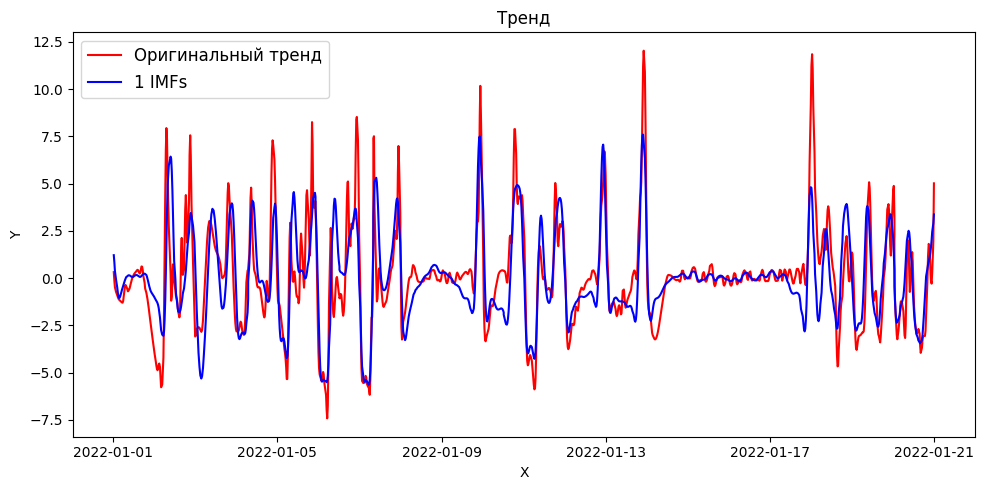

In [54]:
fig, axs = plt.subplots(figsize=(10,5), nrows=1)

axs.plot(index, Component_of_TS, color="#ff0000")
axs.plot(index, imf, color="#0000ff")
plt.title('Тренд', fontsize=12)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(['Оригинальный тренд', '1 IMFs'], prop=FontProperties(size=12))

plt.tight_layout()

In [49]:
residual = TS - imf

In [50]:
alpha = 500
omega_init = 501
tau = 1

fs = 20000
tol = 1e-6

In [51]:
imf, _, _ = VME(residual, Alpha=alpha, omega_int=omega_init, fs=fs, tau=tau, tol=tol)

C:\Users\George\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\series.py:1031: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.asarray(values, dtype=dtype)


In [52]:
Season = u[2]+u[1]
Component_of_TS = Season[::]


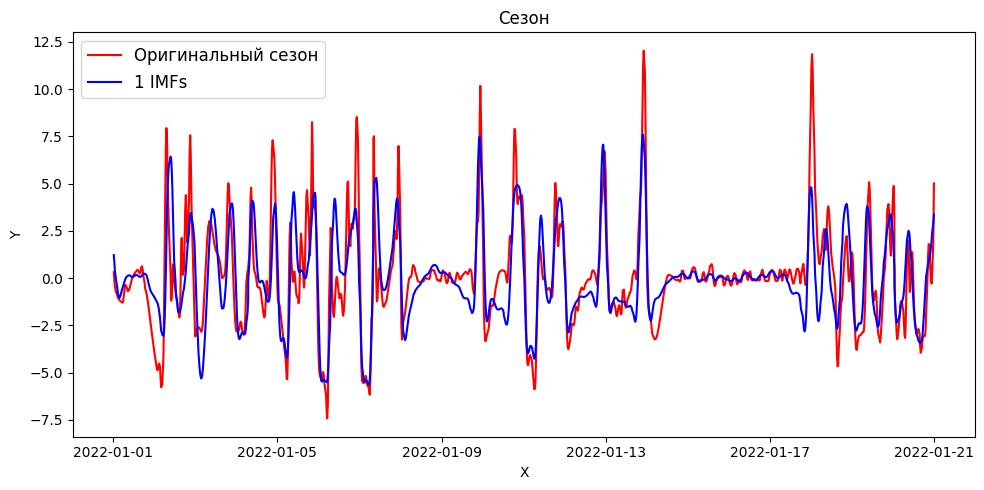

In [55]:
fig, axs = plt.subplots(figsize=(10,5), nrows=1)

axs.plot(index, Component_of_TS, color="#ff0000")
axs.plot(index, imf, color="#0000ff")
plt.title('Сезон', fontsize=12)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(['Оригинальный сезон', '1 IMFs'], prop=FontProperties(size=12))

plt.tight_layout()

In [59]:
Noise = u[0]
Component_of_TS = Noise[::]

In [60]:
noise = residual - imf

C:\Users\George\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\George\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


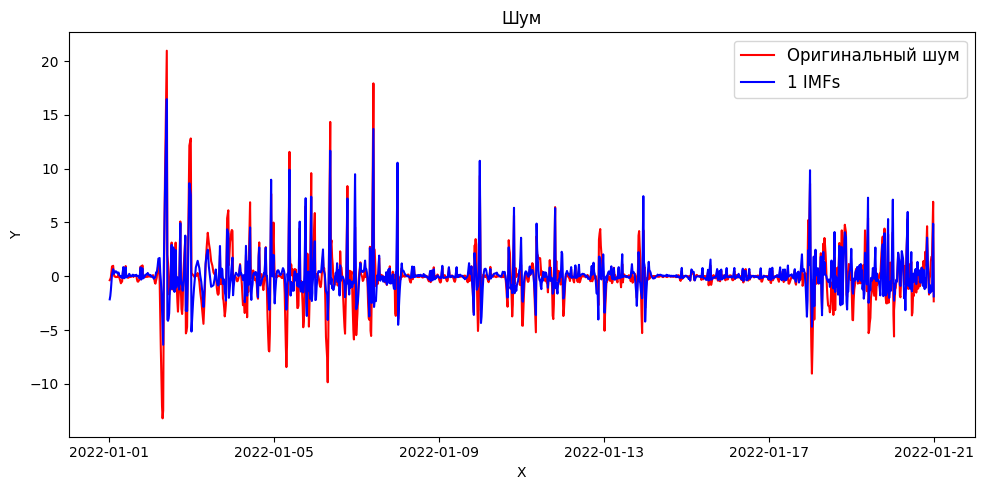

In [61]:
fig, axs = plt.subplots(figsize=(10,5), nrows=1)

axs.plot(index, Component_of_TS, color="#ff0000")
axs.plot(index, noise, color="#0000ff")
plt.title('Шум', fontsize=12)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(['Оригинальный шум', '1 IMFs'], prop=FontProperties(size=12))

plt.tight_layout()

# Тренд

In [10]:
# набор параметров
alpha = (0, 500, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000) # moderate bandwidth constraint
omega_init = (1, 501, 1001, 2501, 5001, 7501, 10001, 15001, 20001, 25001, 30001, 35001, 40001, 45001, 50001)
tau = (0, 1, 2, 3, 4, 5) # noise-tolerance (no strict fidelity enforcement)
fs = 20000
tol = 1e-6

featurecount = 5
params_set = list(product(alpha, omega_init, tau))

In [11]:
best_params = np.zeros((10), dtype=dict)
best_metriks = np.zeros((4), dtype=dict)

f = np.zeros((1228), dtype=list)
k_i = 0


In [12]:
#  R2
MetricName = "R2"
calculate_metric = lambda y, y_pred: r2_score(y, y_pred)

default_value = -np.inf
maxmin = lambda criteria: np.max(criteria)
arg_maxmin = lambda criteria: np.argmax(criteria)
find_new_best_params = lambda max_criteria, best_metriks: max_criteria > best_metriks


# #  R2Adj
# MetricName = "R2Adj"
# calculate_metric = lambda y, y_pred, featurecount: r2_score_adjusted(y, y_pred, featurecount)


# #  AIC
# MetricName = "AIC"
# calculate_metric = lambda y, y_pred, k: calculate_aic(y, y_pred, k)

# default_value = np.inf
# maxmin = lambda criteria: np.min(criteria)
# arg_maxmin = lambda criteria: np.argmin(criteria)
# find_new_best_params = lambda max_criteria, best_metriks: max_criteria < best_metriks


# # BIC
# MetricName = "BIC"
# calculate_metric = lambda y, y_pred, k: calculate_bic(y, y_pred, k)

In [ ]:
# best_metriks = np.zeros(4, dtype=dict)
# best_params = np.zeros(10, dtype=dict)

# best_metriks[0] = {"Time Series": "Dehli-Temerature", "Component": "Trend", f"{MetricName}": default_value}
# best_metriks[1] = {"Time Series": "Dehli-Temerature", "Component": "Season", f"{MetricName}": default_value}
# best_metriks[2] = {"Time Series": "Dehli-Temerature", "Component": "Noise", f"{MetricName}": default_value}
# best_metriks[3] = {"Time Series": "Dehli-Temerature", "Component": "Noise-freg", f"{MetricName}": default_value}

# for j in range(10):
#     best_params[j] = {"Time Series": "Dehli-Temerature", "Metric": f"{MetricName}", "Trend/Season/Noise": None, "IMFs" : f"1 - {j+1}",  "alpha": 0, "tau": 0, "W init": 1}

In [ ]:
# # для всех лчм

# f = TS[::]
# k_i = 0

# best_imfs = 0
# sum_imfs = 0
# isbest_params = True

# criteria = np.zeros(len(alpha)*len(omega_init)*len(tau), dtype=float)

# while( (k_i < 10) and isbest_params ):
#     isbest_params = False
#     criteria.fill(0)
#     # для всех значений alpha
    
#     j = 0          # j - индекс значения параметра
#     for params_i in params_set:
#         u, _, _ = VME(f, Alpha=params_i[0], omega_int=params_i[1], fs=20000, tau=params_i[2], tol=1e-6)

#         criteria[j] = calculate_metric(Trend, u.T.real + sum_imfs)
#         j += 1
    
#     max_criteria = maxmin(criteria)
#     argmax_criteria = arg_maxmin(criteria)

#     if ( find_new_best_params(max_criteria, best_metriks[0][f"{MetricName}"]) ):
#         best_metriks[0][f"{MetricName}"] = max_criteria

#         best_params[k_i]["IMFs"] = f'1 --- {k_i+1}'
#         best_params[k_i]["Trend/Season/Noise"] = "Trend"
#         best_params[k_i]["alpha"] = params_set[argmax_criteria][0]
#         best_params[k_i]["W init"] = params_set[argmax_criteria][1]
#         best_params[k_i]["tau"] = params_set[argmax_criteria][2]
        
#         u, _, _ = VME(f, best_params[k_i]["alpha"], omega_int=1, fs=20000, tau=1, tol=1e-6)
#         best_imfs = u.T.real
#         isbest_params = True
    



#     k_i+=1
#     sum_imfs += best_imfs
#     if(isbest_params):
#         f = f - best_imfs

In [ ]:
# best_metriks[0][f"{MetricName}"] = format(best_metriks[0][f"{MetricName}"], ".5f")

# Сезон

In [ ]:
# # для всех лчм

# season_k = k_i

# best_imfs = 0
# sum_imfs = 0
# isbest_params = True

# criteria = np.zeros(len(alpha)*len(omega_init)*len(tau), dtype=float)

# while( (k_i < 10) and isbest_params ):
#     isbest_params = False
#     criteria.fill(0)
#     # для всех значений alpha
    
#     j = 0          # j - индекс значения параметра
#     for params_i in params_set:
#         u, _, _ = VME(f, Alpha=params_i[0], omega_int=params_i[1], fs=20000, tau=params_i[2], tol=1e-6)

#         criteria[j] = calculate_metric(Trend, u.T.real + sum_imfs)
#         j += 1
    
#     max_criteria = maxmin(criteria)
#     argmax_criteria = arg_maxmin(criteria)

#     if ( find_new_best_params(max_criteria, best_metriks[1][f"{MetricName}"]) ):
#         best_metriks[1][f"{MetricName}"] = max_criteria

#         best_params[k_i]["IMFs"] = f'{season_k} --- {k_i+1}'
#         best_params[k_i]["Trend/Season/Noise"] = "Trend"
#         best_params[k_i]["alpha"] = params_set[argmax_criteria][0]
#         best_params[k_i]["W init"] = params_set[argmax_criteria][1]
#         best_params[k_i]["tau"] = params_set[argmax_criteria][2]
        
#         u, _, _ = VME(f, best_params[k_i]["alpha"], omega_int=1, fs=20000, tau=1, tol=1e-6)
#         best_imfs = u.T.real
#         isbest_params = True
    



#     k_i+=1
#     sum_imfs += best_imfs
#     if(isbest_params):
#         f = f - best_imfs

In [ ]:
# best_metriks[1][f"{MetricName}"] = format(best_metriks[1][f"{MetricName}"], ".5f")

In [ ]:
best_params

array([{'Time Series': 'Dehli-Temerature', 'Metric': 'BIC', 'Trend/Season/Noise': 'Trend', 'IMFs': '1 --- 1', 'alpha': 30000, 'tau': 0, 'W init': 1},
       {'Time Series': 'Dehli-Temerature', 'Metric': 'BIC', 'Trend/Season/Noise': None, 'IMFs': '1 - 2', 'alpha': 0, 'tau': 0, 'W init': 1},
       {'Time Series': 'Dehli-Temerature', 'Metric': 'BIC', 'Trend/Season/Noise': 'Season', 'IMFs': '2 --- 2', 'alpha': 0, 'tau': 0, 'W init': 1},
       {'Time Series': 'Dehli-Temerature', 'Metric': 'BIC', 'Trend/Season/Noise': 'Season', 'IMFs': '2 --- 3', 'alpha': 2500, 'tau': 3, 'W init': 501},
       {'Time Series': 'Dehli-Temerature', 'Metric': 'BIC', 'Trend/Season/Noise': 'Season', 'IMFs': '2 --- 4', 'alpha': 50000, 'tau': 4, 'W init': 1},
       {'Time Series': 'Dehli-Temerature', 'Metric': 'BIC', 'Trend/Season/Noise': None, 'IMFs': '1 - 6', 'alpha': 0, 'tau': 0, 'W init': 1},
       {'Time Series': 'Dehli-Temerature', 'Metric': 'BIC', 'Trend/Season/Noise': None, 'IMFs': '1 - 7', 'alpha': 0, '

In [ ]:
# one_dimensional_best_params = best_params[::]

# best_params_output = [v for v in one_dimensional_best_params if not (v['Trend/Season/Noise'] is None)]
best_params_output

[{'Time Series': 'Dehli-Temerature',
  'Metric': 'BIC',
  'Trend/Season/Noise': 'Trend',
  'IMFs': '1 --- 1',
  'alpha': 30000,
  'tau': 0,
  'W init': 1},
 {'Time Series': 'Dehli-Temerature',
  'Metric': 'BIC',
  'Trend/Season/Noise': 'Season',
  'IMFs': '2 --- 2',
  'alpha': 0,
  'tau': 0,
  'W init': 1},
 {'Time Series': 'Dehli-Temerature',
  'Metric': 'BIC',
  'Trend/Season/Noise': 'Season',
  'IMFs': '2 --- 3',
  'alpha': 2500,
  'tau': 3,
  'W init': 501},
 {'Time Series': 'Dehli-Temerature',
  'Metric': 'BIC',
  'Trend/Season/Noise': 'Season',
  'IMFs': '2 --- 4',
  'alpha': 50000,
  'tau': 4,
  'W init': 1}]

In [ ]:
np.shape(one_dimensional_best_params)

(10,)

In [ ]:
np.shape(best_params_output)

(4,)

In [ ]:
# filename=f"./Output-VME/Parameters-{MetricName}-VME.csv"

# fields = best_params[0].keys()
# fields = list(fields)

# with open(filename, mode='w', newline='') as file:
#     writer = csv.DictWriter(file, fieldnames=fields)
#     writer.writeheader()  # Write header row

#     writer.writerows(best_params_output)  # Write data rows

# Шум

In [ ]:
# criteria = calculate_metric(Noise, f, featurecount)
# if (find_new_best_params(criteria, best_metriks[2][f"{MetricName}"])):
#     best_metriks[2][f"{MetricName}"] = criteria

# ШУМ freguency

In [ ]:

# original_noise = np.abs(np.fft.rfft(Noise))
# imf_freg = np.abs(np.fft.rfft(f.astype(float)))

# criteria = calculate_metric(original_noise, imf_freg, featurecount)
# if (find_new_best_params(criteria, best_metriks[3][f"{MetricName}"])):
#     best_metriks[3][f"{MetricName}"] = criteria

# Вывод

In [ ]:
# filename=f"./Output-VME/Best_Metriks-{MetricName}-VME.csv"

# fields = best_metriks[3].keys()
# fields = list(fields)

# with open(filename, mode='w', newline='') as file:
#     writer = csv.DictWriter(file, fieldnames=fields)
#     writer.writeheader()  # Write header row

#     writer.writerows([best_metriks[0]])  # Write data rows
#     writer.writerows([best_metriks[1]])  # Write data rows
#     writer.writerows([best_metriks[2]])  # Write data rows
#     writer.writerows([best_metriks[3]])  # Write data rows